Trying to make a FCN to predict dihedral angles. Some of the code adapted from Jeppe's openprotein https://github.com/biolib/openprotein. The data is from https://github.com/aqlaboratory/proteinnet casp7, text based.

In [1]:
import numpy as np
import torch
import imp
import re
import matplotlib.pyplot as plt

In [2]:
aa_id_dict = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,
              'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 
              'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}


First define some helper functions.

In [3]:
def aa_to_onehot(aa_str, aa_to_nr, mask=None):
    """
    Onehot encode an amino acid string using a letter to number dictionary.
    The mask (from proteinnet files) is used to remove residues missing atoms from the primary sequence.
    """
    if mask!=None:
        mask_ind = np.asarray([x=='+' for x in mask])*1
        mask_ind = np.nonzero(mask_ind)
        aa_str = "".join([aa_str[x] for x in mask_ind[0]]) # the mask indices are a list in a list
    init_array = np.zeros( (len(aa_to_nr.keys()), len(aa_str)) )
    for i,j in enumerate(aa_str):
        init_array[aa_to_nr[j], i] = 1
    return(init_array)

def filter_primary(aa_str, mask):
    '''
    Need this later on for writing pdb files, but should probably just use it at the start...
    '''
    mask_ind = np.asarray([x=='+' for x in mask])*1
    mask_ind = np.nonzero(mask_ind)
    aa_str = "".join([aa_str[x] for x in mask_ind[0]]) # the mask indices are a list in a list
    return(aa_str)

In [4]:
def read_proteinnet_file(file, stop_at=1000, verbose=True):
    """
    Read a proteinnet file. Will also filter the 3D coordinates using the mask
    and remove proteins with chainbreaks and missing structures. 
    A certain number of proteins are loaded.
    """
    protein_dict = {}
    with open(file) as input:
        lines = input.readlines()
        curr_id = None
        for i, line in enumerate(lines):
            line = line.strip()
            if line == '[ID]':
                curr_id = lines[i+1].strip()
                protein_dict[curr_id] = {}
                protein_dict[curr_id]['primary'] = lines[i+3].strip()
            if line == '[TERTIARY]':
                coords = []
                for j in range(3):
                    coords.append(np.fromstring(lines[i+j+1], sep='\t'))
                protein_dict[curr_id]['tertiary'] = np.array(coords)
            if line == '[MASK]':
                protein_dict[curr_id]['mask'] = lines[i+1].strip()
            if len(protein_dict.keys()) >= stop_at:
                break
    filter_seqs(protein_dict, verbose)
    return(protein_dict)

In [5]:
def filter_coords(coords, mask):
    """
    Filter atomic coordinates (for residues missing some) using the mask.
    coords = 3*(N*3) array, since each residue has N, CA and C
    """
    mask = np.array([x=='+' for x in mask])
    mask_stretched = np.repeat(mask, 3)
    coords_filt = coords[:, mask_stretched]
    return(coords_filt)

def filter_seqs(protein_dict, verbose):
    re_chainbreak = re.compile("\-*\+*\+\-+\+\+*\-*") # match for a mask with internal chainbreaks
    keys_to_remove = {}
    for key in protein_dict.keys():
        if len(protein_dict[key].keys()) < 3:
            keys_to_remove[key] = ' missing structure, removing...'
            continue
        mask = protein_dict[key]['mask']
        if re_chainbreak.search(mask):
            keys_to_remove[key] = " has a chainbreak, removing..."
        else:
            coords = protein_dict[key]['tertiary']
            coords_filt = filter_coords(coords, mask)
            protein_dict[key]['tertiary'] = coords_filt
    for key in keys_to_remove.keys():
        if verbose:
            print(key, keys_to_remove[key])
        del protein_dict[key]

def new_dihedral(p0, p1, p2, p3):
    """Praxeolitic formula
    1 sqrt, 1 cross product
    
    copied from 
    https://stackoverflow.com/questions/20305272/
    dihedral-torsion-angle-from-four-points-in-cartesian-coordinates-in-python"""

    b0 = -1.0*(p1 - p0)
    b1 = p2 - p1
    b2 = p3 - p2

    # normalize b1 so that it does not influence magnitude of vector
    # rejections that come next
    b1 /= np.linalg.norm(b1)

    # vector rejections
    # v = projection of b0 onto plane perpendicular to b1
    #   = b0 minus component that aligns with b1
    # w = projection of b2 onto plane perpendicular to b1
    #   = b2 minus component that aligns with b1
    v = b0 - np.dot(b0, b1)*b1
    w = b2 - np.dot(b2, b1)*b1

    # angle between v and w in a plane is the torsion angle
    # v and w may not be normalized but that's fine since tan is y/x
    x = np.dot(v, w)
    y = np.dot(np.cross(b1, v), w)
    #return np.degrees(np.arctan2(y, x))
    return np.arctan2(y, x)

def calc_angles(coords):
    '''
    Basically loops over the coordinates and calculates the dihedral angles.
    There should be ways to do this with vectorized computations but I don't know how.
    '''
    N = coords.shape[1]
    angles_all = []
    for i in range(0, N-3, 3):
        psi = new_dihedral(*[coords[:, x] for x in range(i, i+4)])
        omega = new_dihedral(*[coords[:, x] for x in range(i+1, i+5)])
        phi = new_dihedral(*[coords[:, x] for x in range(i+2, i+6)])
        angles = [psi, omega, phi]
        angles_all.append(angles)
    return(np.array(angles_all))

Load some proteins.

In [6]:
train_proteins = read_proteinnet_file('/Users/Deathvoodoo/big_folders_docs/data/casp7/training_70', 3000, verbose=False)
val_proteins = read_proteinnet_file('/Users/Deathvoodoo/big_folders_docs/data/casp7/validation', 200, verbose=False)

Use the function below to transform the sequences and coordinates into one-hot encoding and dihedral angles. The easiest thing to do would be to pad everything to the length of the longest protein and put it in one tensor, but this has consequences for the output of the network later (nonzero outputs at places that should be zero).
<br>
<br>
Note that since I don't have access to powerful compute resources I'm only running with a small number of proteins for training and validation.

In [7]:
def get_onehot_angles(protein_dict, pad, max_length=1500):
    """
    Get onehot sequence and calculate angles from 3d coords for the protein dictionary.
    Sometimes the angle calculation will produce nans, we remove those sequences.
    If pad==True we will numbers as tensors, otherwise lists, along with remaining ids.
    """
    remaining_ids = list(protein_dict.keys())
    sequence_list = []
    angle_list = []
    for key in protein_dict.keys():
        sequence = aa_to_onehot(protein_dict[key]['primary'], aa_id_dict, protein_dict[key]['mask'])
        coords = protein_dict[key]['tertiary']
        angles = calc_angles(coords).T
        if pad:
            if max_length-sequence.shape[0] < 0:
                print(key, ' exceeds max length: ', max_length, ' , skipping...')
                continue
            else:
                # pad the width, current shape is C*W
                sequence_padded = np.pad(
                    sequence, pad_width = ((0,0), (0, max_length-sequence.shape[1])), 
                    constant_values = 0)
                sequence_list.append(sequence_padded)
                angles_padded = np.pad(
                    angles, pad_width = ((0,0), (0, max_length-sequence.shape[1])),
                    constant_values = 0)
                angle_list.append(angles_padded)
        else: 
            angle_list.append(angles)
            sequence_list.append(sequence)
    N = len(sequence_list)
    have_nans = []
    for i,j in enumerate(angle_list):
        if np.isnan(j).any():
            have_nans.append(i)
    inds_to_keep = np.arange(N)[np.logical_not(np.isin(np.arange(N), have_nans))].tolist()
    
    sequence_list = [sequence_list[i] for i in inds_to_keep]
    angle_list = [angle_list[i] for i in inds_to_keep]
    remaining_ids = [remaining_ids[i] for i in inds_to_keep]
    if pad:
        sequence_tensor = torch.tensor(sequence_list).float()
        sequence_tensor = sequence_tensor #.unsqueeze(1)
        angle_tensor = torch.tensor(angle_list).float()
        angle_tensor = angle_tensor #.unsqueeze(1)
        return([sequence_tensor, angle_tensor, remaining_ids])
    else:
        for i in range(len(sequence_list)):
            ith_seq = (torch.tensor(sequence_list[i]).float()).unsqueeze(0)
            sequence_list[i] = ith_seq #.unsqueeze(0)
            ith_angles = (torch.tensor(angle_list[i]).float()).unsqueeze(0)
            angle_list[i] = ith_angles #.unsqueeze(0)
        return([sequence_list, angle_list, remaining_ids])

In [8]:
train_seqs, train_angles, train_ids_remain = get_onehot_angles(train_proteins, pad=False)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


In [9]:
val_seqs, val_angles, val_ids_remain = get_onehot_angles(val_proteins, pad=False)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


We will also calculate sin and cos to transform the angles into better values for the squared loss error function.

In [10]:
def get_sin_cos(array, as_torch_tensor=True):
    sin = np.sin(array)
    cos = np.cos(array)
    sin_cos = np.concatenate([sin, cos], axis=1)
    if as_torch_tensor:
        sin_cos = torch.tensor(sin_cos)
    return(sin_cos)

def back_to_angle(sin_cos_array, n_angles=3):
    angles = []
    for i in range(n_angles):
        angles_i = np.arctan2(sin_cos_array[:, i, :], sin_cos_array[:, n_angles+i, :])
        # remember that we input sin first due to atan2 definition
        angles_i = angles_i[:, np.newaxis, :]
        angles.append(angles_i)
    angles_arr = np.concatenate(angles, 1)
    return(angles_arr)

In [11]:
train_angles_sin_cos = [get_sin_cos(i) for i in train_angles]
val_angles_sin_cos = [get_sin_cos(i) for i in val_angles]

We write a dataset class for the torch DataLoader. Since we also want to pad the minibatches instead of everything, we also need a custom collate function to deal with this. 

In [12]:
from torch.utils.data import Dataset
class proteindataset(torch.utils.data.Dataset):
    def __init__(self, seqs, angles):
        self.sequences = seqs
        self.angles = angles

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return [self.sequences[idx], self.angles[idx]]

def protein_collate(batch):
    seqs = [item[0] for item in batch]
    angles = [item[1] for item in batch]
    max_len = max([x.shape[2] for x in seqs])
    for i in range(len(batch)):
        curr_len = seqs[i].shape[2]
        seq_padded = np.pad(seqs[i], ((0,0 ), (0,0), (0,max_len-curr_len)), constant_values = 0)
        angles_padded = np.pad(angles[i], ((0,0 ), (0,0), (0,max_len-curr_len)), constant_values = 0)
        seqs[i] = torch.tensor(seq_padded)
        angles[i] = torch.tensor(angles_padded)
    seq_tensor = torch.cat(seqs, 0)
    angle_tensor = torch.cat(angles, 0)
    return([seq_tensor, angle_tensor])
    

In [13]:
train_dataset = proteindataset(train_seqs, train_angles_sin_cos)
val_dataset = proteindataset(val_seqs, val_angles_sin_cos)

In [14]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2, collate_fn=protein_collate)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=100,
                                         shuffle=False, num_workers=2, collate_fn=protein_collate)
#testloader = torch.utils.data.DataLoader(test_dataset, batch_size=100,
                                         #shuffle=False, num_workers=2)

Define and run a FCN with mean squared error as loss function. Angles are transformed to sin/cos and will be backtransformed with arctan 2 after training
<br>
First half of the network does convolution and the second half does up-convolution. It also has some skip connections like the U-NET architecture (but simpler).
<br>
<br>
The proteins are encoded as $N*C*L$ where $C$ = 20 (number of amino acids) and $L$ = length.

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv1d(20, 20, kernel_size=1)
        self.conv0_bn = torch.nn.BatchNorm1d(20)
        self.conv1 = nn.Conv1d(20, 15, kernel_size=4) # down
        self.conv1_bn = torch.nn.BatchNorm1d(15)
        self.conv2 = nn.Conv1d(15, 30, kernel_size=4) # down 
        self.conv2_bn = torch.nn.BatchNorm1d(30)
        self.conv3 = nn.Conv1d(30, 24, kernel_size=6) # down, valley
        self.conv3_bn = torch.nn.BatchNorm1d(24)
        self.conv4 = nn.Conv1d(24, 24, kernel_size=1)
        self.conv4_bn = torch.nn.BatchNorm1d(24)
        
        self.deconv1 = nn.ConvTranspose1d(in_channels=24, out_channels=30, kernel_size=6) # up
        self.deconv1_bn = torch.nn.BatchNorm1d(30)
        self.conv5 = nn.Conv1d(30, 30, 1)
        self.conv5_bn = torch.nn.BatchNorm1d(30)
        
        self.deconv2 = nn.ConvTranspose1d(in_channels=60, out_channels=15, kernel_size=4) # up
        self.deconv2_bn = torch.nn.BatchNorm1d(15)
        self.conv6 = nn.Conv1d(15, 15, 1)
        self.conv6_bn = torch.nn.BatchNorm1d(15)
        
        self.deconv3 = nn.ConvTranspose1d(in_channels=30, out_channels=15, kernel_size=3) # up
        self.deconv3_bn = torch.nn.BatchNorm1d(15)
        self.conv7 = nn.Conv1d(15, 6, (1))
        self.conv7_bn = torch.nn.BatchNorm1d(6)
        self.conv8 = nn.Conv1d(6, 6, 1)
        self.conv8_bn = torch.nn.BatchNorm1d(6)
        self.conv9 = nn.Conv1d(6, 6, 1)

    def forward(self, x):
        conv0_out = F.relu(self.conv0_bn(self.conv0(x)))
        conv1_out = F.relu(self.conv1_bn(self.conv1(conv0_out)))
        conv2_out = F.relu(self.conv2_bn(self.conv2(conv1_out)))
        conv3_out = F.relu(self.conv3_bn(self.conv3(conv2_out)))
        conv4_out = F.relu(self.conv4_bn(self.conv4(conv3_out)))

        deconv1_out = F.relu(self.deconv1_bn(self.deconv1(conv4_out)))
        conv5_out = F.relu(self.conv5_bn(self.conv5(deconv1_out)))
        
        deconv2_input = torch.cat((conv2_out, deconv1_out), 1)  
        deconv2_out = F.relu(self.deconv2_bn(self.deconv2(deconv2_input)))
        conv6_out = F.relu(self.conv6_bn(self.conv6(deconv2_out)))
        
        deconv3_input = torch.cat((conv1_out, deconv2_out), 1)
        deconv3_out = F.relu(self.deconv3_bn(self.deconv3(deconv3_input)))
        conv7_out = F.relu(self.conv7_bn(self.conv7(deconv3_out)))
        conv8_out = F.relu(self.conv8_bn(self.conv8(conv7_out)))
        conv9_out = self.conv9(conv8_out)
        return conv9_out



Train the network.

In [16]:
net = Net()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

prints_per_epoch = 5

verbose_k = np.floor(len(trainloader)/prints_per_epoch)


train_losses = []
val_losses = []
iterations = []
best_loss = None

for epoch in range(20):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        sequence, true_angles = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        predicted_angles = net(sequence)

        loss = criterion(predicted_angles, true_angles)
        loss.backward()
        optimizer.step()
        
        # adding to running loss, we will output this at every verbose_k
        running_loss += loss.item()
        
        if (i+1) % verbose_k == 0:   
            train_losses.append(running_loss/verbose_k)
            true_iter = len(trainloader)*epoch + i
            iterations.append(true_iter)
            net.eval()
            validation_loss = 0
            for k,j in enumerate(val_seqs):
                pred_k = net(j)
                loss_k = criterion(pred_k, val_angles_sin_cos[k]).item()
                validation_loss += loss_k/len(val_seqs)
            val_losses.append(validation_loss)
            net.train()
            print('epoch: {}, iteration: {}] training loss: {}, validation_loss: {}'.format(
                epoch, i, running_loss/verbose_k, validation_loss))
            
            if best_loss == None:
                best_loss = validation_loss
            else:
                if validation_loss <= min(val_losses):
                    print('new best validation loss, saving..')
                    best_loss = validation_loss
                    torch.save(net.state_dict(), 'best_fcn_parameters.pt')

            running_loss = 0.0

print('Finished Training')

epoch: 0, iteration: 118] training loss: 0.3886937973629527, validation_loss: 0.46820328157881036
epoch: 0, iteration: 237] training loss: 0.2324230488107986, validation_loss: 0.2792795018194625
new best validation loss, saving..
epoch: 0, iteration: 356] training loss: 0.15351772408525483, validation_loss: 0.23280459401770412
new best validation loss, saving..
epoch: 0, iteration: 475] training loss: 0.13537751758048513, validation_loss: 0.21611089037256945
new best validation loss, saving..
epoch: 0, iteration: 594] training loss: 0.13168821702985203, validation_loss: 0.20830925313397225
new best validation loss, saving..
epoch: 1, iteration: 118] training loss: 0.12634562056104676, validation_loss: 0.20258381363490366
new best validation loss, saving..
epoch: 1, iteration: 237] training loss: 0.12478696016453895, validation_loss: 0.19833944548175944
new best validation loss, saving..
epoch: 1, iteration: 356] training loss: 0.11848319359436757, validation_loss: 0.1954507358279658
ne

epoch: 14, iteration: 594] training loss: 0.09873566488508417, validation_loss: 0.17874623724022262
epoch: 15, iteration: 118] training loss: 0.09886539912148684, validation_loss: 0.17888176182042004
epoch: 15, iteration: 237] training loss: 0.10109624748720843, validation_loss: 0.1813052863067722
epoch: 15, iteration: 356] training loss: 0.09968566628439086, validation_loss: 0.17943687924409496
epoch: 15, iteration: 475] training loss: 0.1040238587170088, validation_loss: 0.17924762517213827
epoch: 15, iteration: 594] training loss: 0.10321016136963829, validation_loss: 0.18325060235787619
epoch: 16, iteration: 118] training loss: 0.09723991609546316, validation_loss: 0.18258730099993453
epoch: 16, iteration: 237] training loss: 0.1025719756902266, validation_loss: 0.17904570087883043
epoch: 16, iteration: 356] training loss: 0.10020888537293722, validation_loss: 0.17911090257560228
epoch: 16, iteration: 475] training loss: 0.10323832716260638, validation_loss: 0.18102109948207876
epo

In [17]:
net.load_state_dict(torch.load('/Users/Deathvoodoo/big_folders_docs/random/best_fcn_parameters.pt'))

net.eval()

validation_preds = [net(i) for i in val_seqs]

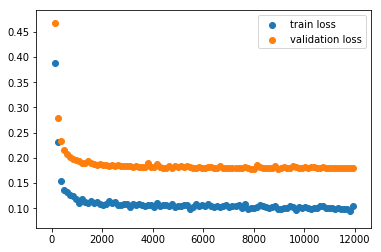

In [18]:
plt.scatter(iterations, train_losses, label='train loss')
plt.scatter(iterations, val_losses, label='validation loss')
plt.legend()
plt.show()

Let's transform the predicted values back to angles and compare.

In [19]:
validation_preds_angles = [back_to_angle(i.detach().numpy()) for i in validation_preds] # np instead of torch

In [20]:
import PeptideBuilder
test_protein = val_ids_remain[49]

In [21]:
test_angles_real = val_angles[49].numpy()
test_angles_pred = validation_preds_angles[49]

Need to filter the primary sequences to write pdb files. Could do this at the beginning.

In [22]:
for key in val_proteins.keys():
    val_proteins[key]['primary'] = filter_primary(val_proteins[key]['primary'], val_proteins[key]['mask'])
    

In [23]:
def make_pb_structure(seq_str, angles):
    psi = np.degrees(angles[0, :].tolist())
    omega = np.degrees(angles[1, :].tolist())
    phi = np.degrees(angles[2, :].tolist())
    structure = PeptideBuilder.make_structure(seq_str, phi, psi, omega)
    return(structure)

In [24]:
test_structure_real = make_pb_structure(val_proteins[test_protein]['primary'], test_angles_real[0, :, :])

In [25]:
test_structure_pred = make_pb_structure(val_proteins[test_protein]['primary'], test_angles_pred[0, :, :])

In [26]:
import Bio.PDB
def write_to_pdb(structure, prot_id, identifier):
    out = Bio.PDB.PDBIO()
    out.set_structure(structure)
    out.save(prot_id + identifier + ".pdb")

In [27]:
write_to_pdb(test_structure_real, test_protein, '_real')
write_to_pdb(test_structure_pred, test_protein, '_pred')

We can open the saved pdb files in pymol, align them and save the image. Cyan = predicte, green = true.

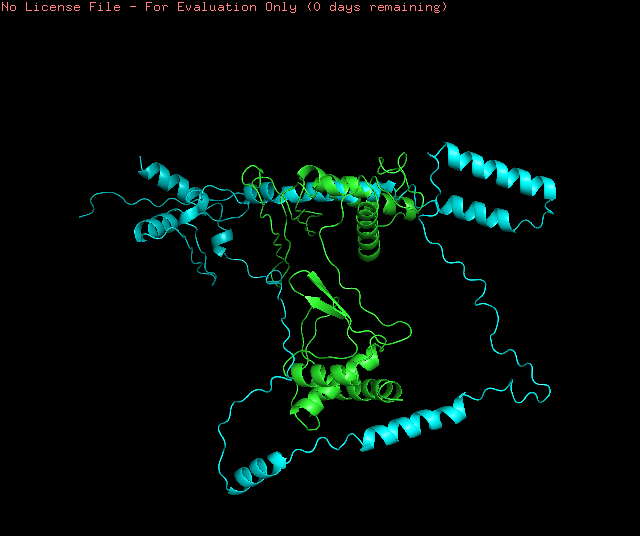

In [31]:
from IPython.display import Image 
im = Image(filename="/Users/Deathvoodoo/big_folders_docs/random/90#1J2P_1_A.png")
display(im)

Well, at least it sort of looks like a protein.
<br>
<br>
Checking distribution of angles for the test protein.

In [29]:
print(test_angles_pred.max())
print(test_angles_real.max())

3.141512
3.1413598


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


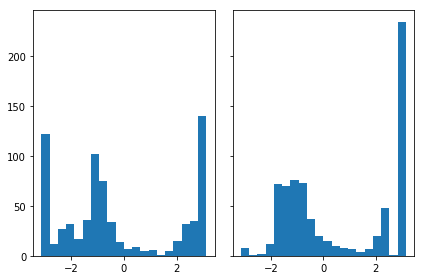

In [30]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
n_bins=20
axs[0].hist(test_angles_real.flatten(), bins=n_bins)
axs[1].hist(test_angles_pred.flatten(), bins=n_bins)
plt.show()

Looking more like angles than previous iterations